# Random Forest (RF): BTC Price Prediction
Source: https://ideas.repec.org/p/pra/mprapa/113293.html  
This paper found that technical indicators were important features in the prediction.  
When predicting values 10- and 20-days, it had an accuracy of 85%-90%+.  
5 day forecast had an accuracy rate of 75%-80%.  


## Why Random Forest?
It is a ML model that makes decisions like a group of people voting to solve a problem, and it uses a lot of decision trees.  
It basically builds many decision trees, and looks at random set of features.  
Each prediction will determine if BTC will go up or down.  
Based on the majority vote, it will determine if it will go up or down. 

## Features to explore
- MA50 (50-day moving average)
- MA200 (200-day moving average)
- MACDSignal (signal line of MACD)
- OBV (On-Balance Volume)
- WAD (Williams Acumulation/Distribution Line)

# Libraries

In [31]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta  
import matplotlib.pyplot as plt

from fredapi import Fred
from datetime import datetime

# BTC Set Up: Fetch Price
From 2018 - Present

In [32]:
# Get today's date in 'YYYY-MM-DD' format
today = datetime.today().strftime('%Y-%m-%d')

# Download daily Bitcoin data from Yahoo Finance
btc = yf.download('BTC-USD', start='2018-01-01', end=today, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [33]:
btc = btc[['Close', 'Volume', 'High', 'Low']]

# Setting up the Data

## Moving Averages (50- & 200- Days)
- Short term: 50 days
- Long term: 200 days

#### Feature Engineering MA_Signal
If:
- Buy: 1
- None: 0 
- Sell: -1

In [34]:
# Calculate Moving Averages
btc['MA50']  = btc['Close'].rolling(window=50).mean()
btc['MA200'] = btc['Close'].rolling(window=200).mean() 

# Use shift to detect crossovers
btc['Prev_MA_50'] = btc['MA50'].shift(1)
btc['Prev_MA_200'] = btc['MA200'].shift(1)

# Initialize numeric signal column
btc['MA_Signal'] = 0  # 1 = Buy, -1 = Sell, 0 = None

# Golden Cross → Buy
btc.loc[
    (btc['Prev_MA_50'] < btc['Prev_MA_200']) & 
    (btc['MA50'] > btc['MA200']),
    'MA_Signal'
] = 1

# Death Cross → Sell
btc.loc[
    (btc['Prev_MA_50'] > btc['Prev_MA_200']) & 
    (btc['MA50'] < btc['MA200']),
    'MA_Signal'
] = -1

# Drop helper columns
btc.drop(columns=['Prev_MA_50', 'Prev_MA_200'], inplace=True)


C:\Users\nones\AppData\Local\Temp\ipykernel_27720\1516586326.py:27: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  btc.drop(columns=['Prev_MA_50', 'Prev_MA_200'], inplace=True)


## Moving Average Convergence Divergence (MACD)
This tracks the difference between short-term and long-term moving averages, which is often 12-day and 26-day) along with a signal line.  
When MACD is positive, it suggests an upward momentum whereas a negative crossover can signal a bearish turn.  

The research paper used MACD and MACDSignal as part of the feature set in the ML model  
They used the default appraoch which is 12-26 day EMA, with MACDSignal being 9 day EMA

Tracks difference between short-term and long-term MAs, it is often 12-day, 26-day & 9 days

Understanding MACD line = EMA(12) - EMA(26)  

Signal Line = EMA(9) of the MACD Line

When MACD > Signal = Uptrend / buy opportunity
When MACD < Signal = Downtrend / sell signal

### Feature engineering "macd_signal_flag" 
If:
- Buy: 1
- None: 0
- Sell: -1

In [35]:
# Calculate MACD and Signal Line using standard EMA periods
ema_12 = btc['Close'].ewm(span=12, adjust=False).mean()
ema_26 = btc['Close'].ewm(span=26, adjust=False).mean()

btc['MACD'] = ema_12 - ema_26
btc['MACD_Signal'] = btc['MACD'].ewm(span=9, adjust=False).mean()

# Initialize numeric signal column only
btc['macd_signal_flag'] = 0  # 1 for Buy, -1 for Sell, 0 for No Signal

# MACD crosses above Signal → Buy (1)
buy_mask = (
    (btc['MACD'].shift(1) < btc['MACD_Signal'].shift(1)) &
    (btc['MACD'] > btc['MACD_Signal'])
)
btc.loc[buy_mask, 'macd_signal_flag'] = 1

# MACD crosses below Signal → Sell (-1)
sell_mask = (
    (btc['MACD'].shift(1) > btc['MACD_Signal'].shift(1)) &
    (btc['MACD'] < btc['MACD_Signal'])
)
btc.loc[sell_mask, 'macd_signal_flag'] = -1


## OBV (On-Balance Volume)
This is a cumulative volume indicator measuring buying/selling pressure.
Rising OBV with price indicates strength (volume confirming the trend), whereas diverging OBV may warn of a reversal.
Other words:
This tracks behavior of traders, it is often viewed as a volume-based sentiment indicator.

If price goes up, OBV adds that day's volume and assumes that buyers are in control (positive sentiment)  
If price goes down, OBV substracts the volume and assumes sellers are in control (negative sentiment)  
If price is flat, OBV does nothing that day  

In the research paper, the only used OBV as is, no transformation was used

In [36]:
btc.columns = ['_'.join(col).strip('_') for col in btc.columns.values]

Code explained:

1. Calculates the day-to-day change in closing price, if today's close is higher than yesterday, it is a positive number. If today is lower, then it is a negative number. First row will always be NaN because there's no previous day. Think of this as, "How much did hte price move compared to yesterday?"

2. Translates the price movement into a direction signal.
- price went up: 1 
- price went down: -1
- no change: 0

3. Multiplies trading volume by the price direction each day:

If price went up, it adds volume (buying pressure)
If price went down, it substracts volume (selling pressure)
Then it cimulatively sums those values across all days

In [37]:
# OBV Calculation
delta = btc['Close_BTC-USD'].diff()                                     # 1
direction = delta.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0)) # 2
btc['OBV'] = (btc['Volume_BTC-USD'] * direction).cumsum()               # 3

## WAD (Williams Acumulation/Distribution Line)  
Its a sensor that tells us what is pushing or pulling based on price AND volume  

In the research paper, they used WAS as a feature, using default settings in R.  
This was the mode important predictor in their random forest model.  
This is what helped determine if BTC would go up or down 10- or 20-days later

### Feature Engineering WAD  
Using High and Low of the day  
For each day:

- If Close > Previous Close → add Volume × [Close − Min(Low, PrevClose)]
- If Close < Previous Close → subtract Volume × [Max(High, PrevClose) − Close]
- If Close == Previous Close → add 0

In [38]:
# Previous day's close
prev_close = btc['Close_BTC-USD'].shift(1)

# Initialize WAD component column
btc['WAD_component'] = 0.0

# Condition 1: Close > Previous Close → buying pressure
buy_condition = btc['Close_BTC-USD'] > prev_close
btc.loc[buy_condition, 'WAD_component'] = (
    (btc['Close_BTC-USD'] - pd.concat([btc['Low_BTC-USD'], prev_close], axis=1).min(axis=1)) *
    btc['Volume_BTC-USD']
)

# Condition 2: Close < Previous Close → selling pressure
sell_condition = btc['Close_BTC-USD'] < prev_close
btc.loc[sell_condition, 'WAD_component'] = (
    (btc['Close_BTC-USD'] - pd.concat([btc['High_BTC-USD'], prev_close], axis=1).max(axis=1)) *
    btc['Volume_BTC-USD']
)

# Final WAD: cumulative sum of daily WAD component
btc['WAD'] = btc['WAD_component'].cumsum()

# Optional: remove intermediate column
btc.drop(columns=['WAD_component'], inplace=True)

### Adding additional column for personal analysis

WAD_signal Indicator – Interpretation & Trade Guidance

- **'Bullish'**:  
  - Price is rising AND WAD is rising  
  - Interpretation: Strong buying pressure is confirming the uptrend.  
  - Action: Consider entering a buy/long position or holding if already in.  
  - Confidence: High — momentum is backed by volume.

- **'Bearish'**:  
  - Price is falling AND WAD is falling  
  - Interpretation: Strong selling pressure is confirming the downtrend.  
  - Action: Consider selling, shorting, or staying out.  
  - Confidence: High — sellers are dominating with volume.

- **'Caution (Bearish Divergence)'**:  
  - Price is rising BUT WAD is falling  
  - Interpretation: Price is going up without volume support — the rally may be weak or fading.  
  - Action: Avoid buying, tighten stop-losses if in a trade. Be cautious — trend may reverse.  
  - Confidence: Medium — watch closely for weakness.

- **'Watch for Reversal'**:  
  - Price is falling BUT WAD is rising  
  - Interpretation: Quiet accumulation — buyers may be entering despite price drops.  
  - Action: Consider monitoring for a bounce, or early entry on reversal confirmation.  
  - Confidence: Medium — potential bullish setup.

- **'Neutral'**:  
  - No significant movement in price or WAD  
  - Interpretation: Market indecision or sideways consolidation.  
  - Action: Wait for a clear signal. No strong trend to act on.  
  - Confidence: Low — signal not actionable.


In [39]:
# Shift price and WAD to get previous values
btc['WAD_prev'] = btc['WAD'].shift(1)
btc['Price_prev'] = btc['Close_BTC-USD'].shift(1)

# Price and WAD movement directions
btc['price_dir'] = btc['Close_BTC-USD'] - btc['Price_prev']
btc['wad_dir'] = btc['WAD'] - btc['WAD_prev']

# Create indicator column
def classify_sentiment(row):
    if row['price_dir'] > 0 and row['wad_dir'] > 0:
        return 'Bullish'
    elif row['price_dir'] < 0 and row['wad_dir'] < 0:
        return 'Bearish'
    elif row['price_dir'] > 0 and row['wad_dir'] < 0:
        return 'Caution (Bearish Divergence)'
    elif row['price_dir'] < 0 and row['wad_dir'] > 0:
        return 'Watch for Reversal'
    else:
        return 'Neutral'

btc['WAD_signal'] = btc.apply(classify_sentiment, axis=1)

# Optional: Drop helper columns
btc.drop(columns=['WAD_prev', 'Price_prev', 'price_dir', 'wad_dir'], inplace=True)


## Tenyrbond 
10-year US Treasury Bond Yield was found to be one of the most important macroeconomic features for longer forecast horizon

In [40]:
import pandas as pd
from fredapi import Fred

# Step 1: Read your FRED API key from a text file
with open("C:/Users/nones/BTC/fre_api_key.txt", "r") as file:
    fred_api_key = file.read().strip()

# Step 2: Initialize FRED connection
fred = Fred(api_key=fred_api_key)

# Step 3: Download daily 10-year U.S. Treasury bond yield (DGS10)
tenyrbond = fred.get_series('DGS10')

# Step 4: Format the data as a DataFrame
tenyrbond_df = tenyrbond.reset_index()
tenyrbond_df.columns = ['Date', 'Tenyrbond']
tenyrbond_df['Date'] = pd.to_datetime(tenyrbond_df['Date'])

# Optional: Fill missing days (e.g., weekends) if needed
tenyrbond_df.set_index('Date', inplace=True)
daily_index = pd.date_range(start=tenyrbond_df.index.min(), end=tenyrbond_df.index.max(), freq='D')
tenyrbond_df = tenyrbond_df.reindex(daily_index)
tenyrbond_df['Tenyrbond'] = tenyrbond_df['Tenyrbond'].ffill()
tenyrbond_df = tenyrbond_df.reset_index()
tenyrbond_df.columns = ['Date', 'Tenyrbond']

# Join the two DF: btc & tenyrbonnd_df

Date was not stored right, now we're making it a column

In [41]:
btc = btc.reset_index()  

In [42]:
len(btc)

2748

Combining btc with tenyrbond_df

In [43]:
# Ensure both Date columns are in datetime format
btc['Date'] = pd.to_datetime(btc['Date'])
tenyrbond_df['Date'] = pd.to_datetime(tenyrbond_df['Date'])

# Merge on 'Date' — only keep dates that exist in btc
btc_rf = pd.merge(btc, tenyrbond_df, on='Date', how='inner')

In [44]:
len(btc_rf)

2747

# Saving the data

## Personal use 

In [45]:
btc_personal = btc_rf

In [46]:
btc_personal.to_csv('btc_personal.csv', index=False)

In [47]:
len(btc_personal)

2747

# Model use

In [48]:
btc_personal.head(1)

,Date,Close_BTC-USD,Volume_BTC-USD,High_BTC-USD,Low_BTC-USD,MA50,MA200,MA_Signal,MACD,MACD_Signal,macd_signal_flag,OBV,WAD,WAD_signal,Tenyrbond
0,2018-01-01,13657.200195,10291200000,14112.200195,13154.700195,NaN,NaN,0,0.0,0.0,0,0,0.0,Neutral,2.4


In [49]:
rf_features = [
    'Date',
    'Close_BTC-USD',
    'Volume_BTC-USD',
    'High_BTC-USD',
    'Low_BTC-USD',
    'MA50',
    'MA200',
    'MACD',
    'MACD_Signal',
    'OBV',
    'WAD',
    'Tenyrbond'
]

In [50]:
btc_rf = btc_rf[rf_features]

#### Save data

In [51]:
btc_rf.to_csv('btc_rf.csv', index=False)

# Random Forest
Putting everything together

Context:  
In the research, they found that RF achieved 90% accuracy for a 20-day forecast  
Under time-series cross validation, it had an accuracy of (83%-89%)  
The model is able to handle nonlinear trends, and was able to handle robust noise (market volatility)  

Assign data to model as a df

In [52]:
model = pd.read_csv("C:/Users/nones/BTC/btc_rf.csv") # for approach 1

### Approach 1:

####  Step 1: Prepare Data for Prediction

In [53]:
# Predicting 10 and 20 days ahead closing prices
model['Price_10d'] = model['Close_BTC-USD'].shift(-10)
model['Price_20d'] = model['Close_BTC-USD'].shift(-20)

# Drop rows with NaN targets
model_rf = model.dropna(subset=['Price_10d', 'Price_20d'])

#### Step 2: Choose Features and Targets

In [54]:
# Feature columns (exclude the targets and ensure no leakage)
features = [
    'Close_BTC-USD', 'Volume_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD',
    'MA50', 'MA200', 'MACD', 'MACD_Signal', 'OBV', 'WAD', 'Tenyrbond'
]

X = model_rf[features]

# Targets
y_10d = model_rf['Price_10d']
y_20d = model_rf['Price_20d']

#### Step 3: Train-Test Split (Time-Series style)

In [55]:
split = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y10_train, y10_test = y_10d.iloc[:split], y_10d.iloc[split:]
y20_train, y20_test = y_20d.iloc[:split], y_20d.iloc[split:]

#### Step 4: Fit Random Forest Models

In [56]:
from sklearn.ensemble import RandomForestRegressor

# Model for 10 days ahead
rf_10d = RandomForestRegressor(n_estimators=200, random_state=42)
rf_10d.fit(X_train, y10_train)

# Model for 20 days ahead
rf_20d = RandomForestRegressor(n_estimators=200, random_state=42)
rf_20d.fit(X_train, y20_train)

RandomForestRegressor(n_estimators=200, random_state=42)

#### Step 5: Evaluate Model Performance

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predictions
y10_pred = rf_10d.predict(X_test)
y20_pred = rf_20d.predict(X_test)

# Performance metrics
rmse_10d = np.sqrt(mean_squared_error(y10_test, y10_pred))
mae_10d = mean_absolute_error(y10_test, y10_pred)

rmse_20d = np.sqrt(mean_squared_error(y20_test, y20_pred))
mae_20d = mean_absolute_error(y20_test, y20_pred)

print("10-Day Ahead Model:")
print(f"RMSE: {rmse_10d:.2f}, MAE: {mae_10d:.2f}")

print("\n20-Day Ahead Model:")
print(f"RMSE: {rmse_20d:.2f}, MAE: {mae_20d:.2f}")

10-Day Ahead Model:
RMSE: 31826.34, MAE: 26828.21

20-Day Ahead Model:
RMSE: 35099.94, MAE: 30870.77


- Root Mean Squared Error (RMSE): Represents the average magnitude of errors. Higher errors have disproportinately greater impact due to squaring
- Mean Absolute Error (MAE): Represents the average magnitude of prediction errors (in absolute terms). Easier to interpret directly.

From the result:
- 10-day ahead: MAE says we are off by ~$25,745.60, on average


- 20-day ahead: MAE says we are off by ~$29,800.12, on average

#### Step 6: Feature Importance

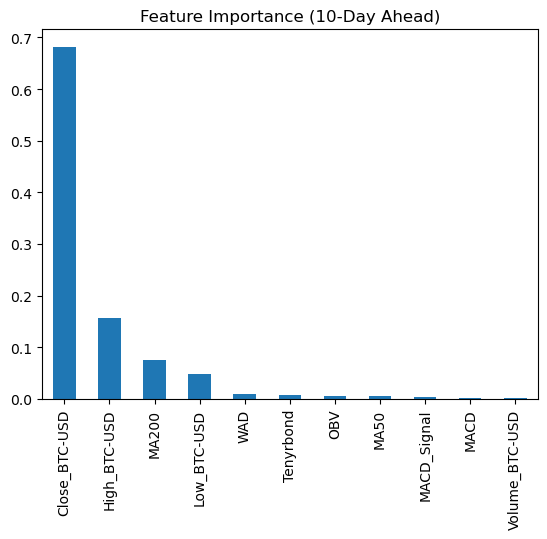

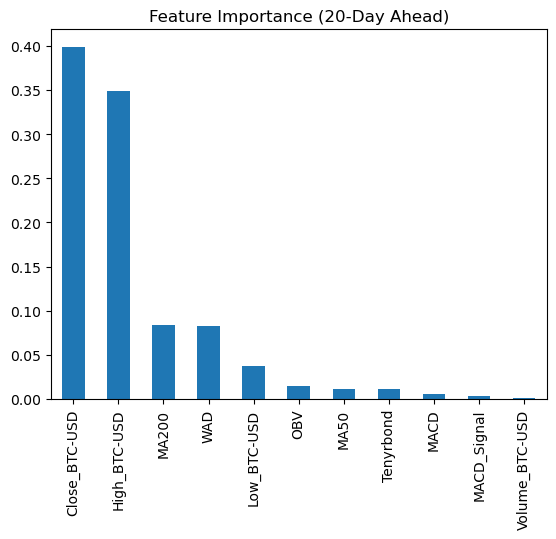

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance (10-day ahead)
importance_10d = pd.Series(rf_10d.feature_importances_, index=features).sort_values(ascending=False)
importance_10d.plot(kind='bar', title='Feature Importance (10-Day Ahead)')
plt.show()

# Feature importance (20-day ahead)
importance_20d = pd.Series(rf_20d.feature_importances_, index=features).sort_values(ascending=False)
importance_20d.plot(kind='bar', title='Feature Importance (20-Day Ahead)')
plt.show()


#### Step 7: Make Actual Future Predictions

In [59]:
latest_data = model[features].iloc[-1:]

# Predict future prices
price_in_10_days = rf_10d.predict(latest_data)[0]
price_in_20_days = rf_20d.predict(latest_data)[0]

print(f"Predicted BTC price 10 days from now: ${price_in_10_days:.2f}")
print(f"Predicted BTC price 20 days from now: ${price_in_20_days:.2f}")

Predicted BTC price 10 days from now: $52952.17
Predicted BTC price 20 days from now: $52635.21


Notes: this is quite off as BTC is currently trending above 110k at current state.


# Conclusion
While this research paper seems promising, my approach to only use their top important features was not sufficient to predict the price of BTC 10- and 20- days ahead.   
Future improvement will need to involve other features that they had included.  
Normalization of the prices could be a point of interest as well as BTC can be quite volatile. 